### 🧭 03_Hypothesis_Testing — Проверка гипотез
В этом ноутбуке проводится статистическая проверка гипотез о влиянии различных признаков на цену квартир в Москве на основе очищенного датасета.

---

## 📋 Основные этапы работы
1. Импорт библиотек
2. Загрузка очищенного датасета `cleaned_flats_moscow.csv`
3. Проверка гипотез:
   - Корреляция количественных признаков с ценой (Spearman)
   - Влияние бинарных категориальных признаков на цену (U-критерий Манна–Уитни)
   - Влияние многогруппового категориального признака `room_type` на цену (тест Крускала–Уоллиса)
4. Визуализация распределений (boxplot)
5. Формулировка выводов по каждой гипотезе

---

## 🎯 Цель
Проверить статистическую значимость влияния ключевых признаков на цену квартиры:
- количественные: `total_area`, `living_area`, `kitchen_area`, `distance_to_center`, `distance_to_metro`
- категориальные: `close_to_center`, `walkable_to_metro`, `is_brick`, `is_middle_floor`, `room_type`

Подтвердить или опровергнуть возможность переноса наблюдаемых зависимостей с выборки на генеральную совокупность.

---

## 1. Импорт библиотек

In [23]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from utils.hypothesis import get_quant_p_values, test_mannwhitney, test_kruskal

## 2. Загрузка и осмотр случайных значений

Для проверки гипотез используется очищенный и подготовленный датасет `cleaned_flats_moscow.csv`, полученный на предыдущем этапе (после предобработки и удаления выбросов).

In [24]:
# Загружаем очищенные данные
flats = pd.read_csv("../data/processed/cleaned_flats_moscow.csv")

In [25]:
flats.sample(5)

,price,total_area,living_area,kitchen_area,distance_to_center,distance_to_metro,walkable_to_metro,is_brick,is_middle_floor,close_to_center,room_type
806,135,68.0,46.0,8.0,12.5,7.0,No,No,Yes,No,3-комнатная
1237,115,77.0,46.0,10.0,13.5,10.0,No,No,Yes,No,3-комнатная
810,135,74.0,51.0,9.0,10.5,7.0,Yes,Yes,Yes,No,3-комнатная
199,93,59.0,44.0,6.0,7.0,5.0,No,No,No,No,2-комнатная
60,75,55.0,39.0,6.0,10.0,10.0,Yes,No,No,No,1-комнатная


---

## Анализ влияния количественных признаков на цену

Гипотезы для каждого признака:

* H0 — корреляцию цены с признаком нельзя переносить с выборки на генеральную совокупность
* H1 — корреляцию цены с признаком можно переносить с выборки на генеральную совокупность

In [26]:
quant_p_values = get_quant_p_values(flats, target="price")
quant_p_values[quant_p_values["p_value"] <= 0.05]

,column,p_value,correlation,method,conclusion
0,total_area,0.0,0.7690,Spearman,Есть статистически значимая разница.
1,living_area,0.0,0.6503,Spearman,Есть статистически значимая разница.
2,kitchen_area,0.0,0.6346,Spearman,Есть статистически значимая разница.
3,distance_to_center,0.0,-0.3178,Spearman,Есть статистически значимая разница.
4,distance_to_metro,0.0,-0.1025,Spearman,Есть статистически значимая разница.


### 🔍 Вывод

Все исследованные количественные признаки имеют **статистически значимую корреляцию с ценой (p ≤ 0.05)**:

- **Положительная корреляция:** общая площадь, жилая площадь, площадь кухни — чем больше площадь, тем выше цена.
- **Отрицательная корреляция:** расстояние до центра и метро — чем дальше объект от центра или метро, тем ниже цена.

Следовательно, можно **переносить корреляцию с выборки на генеральную совокупность** для всех этих признаков.

---

## Анализ влияния пешей доступности до центра на цену

### Гипотезы
- **H0**: Нет значимых различий в цене между квартирами **в пешей доступности до центра** и **остальными**.
- **H1**: Квартиры **в пешей доступности до центра** имеют **значимо другую цену**.

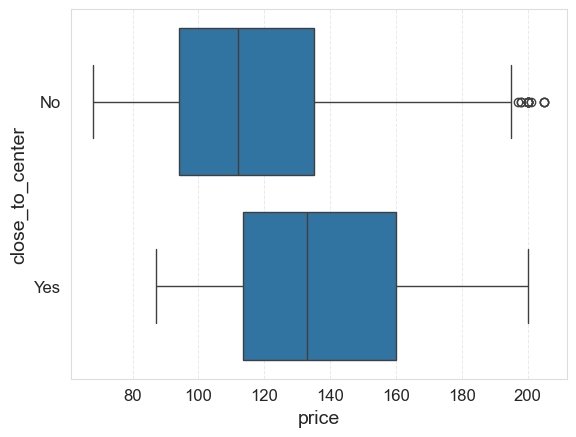

In [27]:
sns.boxplot(flats, y="close_to_center", x="price", orient="h")
plt.show()

In [28]:
flats.groupby("close_to_center")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
close_to_center,,,,,,,,
No,1796.0,116.396993,28.297484,68.0,94.0,112.0,135.0,205.0
Yes,72.0,136.847222,29.455462,87.0,113.5,133.0,160.0,200.0


**Промежуточные заметки:**
- Квартиры в пешей доступности (Yes) — **72 объекта** (~4%), остальные — **1796** (~96%).
- Медиана: **Yes ≈ 135 млн**, **No ≈ 112 млн** → разница **+23 млн** (~+20.5%).
- Среднее: **Yes ≈ 136.8 млн**, **No ≈ 116.4 млн** → разница **+20.4 млн**.
- Разброс (std) ниже у Yes → более однородный премиум-сегмент.
- По boxplot: медианы и распределения явно различаются.

In [29]:
test_mannwhitney(flats, "price", "close_to_center", alternative="two-sided")

close_to_center: p-value=0.0000 → Есть статистически значимая разница.


### 🔍 Вывод
Так как **p-value < 0.05**, нулевая гипотеза **H₀ отвергается**.

- **Пешая доступность до центра оказывает статистически значимое влияние на цену.**
- Квартиры в пешей доступности имеют **значимо более высокую цену** (в среднем на ~20 млн дороже).
- Эффект подтверждается как статистически, так и визуально.

---

---

## Анализ влияния количества комнат в квартире на цену

### Гипотезы
- **H0**: Нет различий в распределении цен между группами по количеству комнат (все медианы равны).
- **H1**: Цены **значимо различаются** хотя бы между двумя группами по числу комнат.

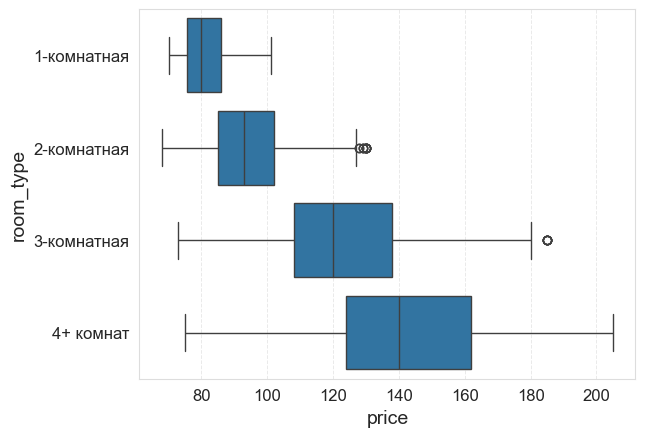

In [30]:
sns.boxplot(flats, y="room_type", x="price", orient="h")
plt.show()

In [31]:
flats.groupby("room_type")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
1-комнатная,120.0,81.925000,7.477881,70.0,75.75,80.0,86.0,101.0
2-комнатная,578.0,94.901384,12.361495,68.0,85.00,93.0,102.0,130.0
3-комнатная,719.0,124.350487,21.423625,73.0,108.00,120.0,138.0,185.0
4+ комнат,451.0,143.702882,26.384599,75.0,124.00,140.0,162.0,205.0


### Промежуточные заметки:

- Медианы растут с количеством комнат: **80 → 93 → 120 → 140 млн**.
- Средние значения подтверждают тренд: чем больше комнат — тем выше цена.
- Разброс (std) увеличивается с ростом числа комнат → больше вариативности в премиум-сегменте.
- По boxplot: чёткое разделение групп, медианы не пересекаются.


In [32]:
test_kruskal(flats, "price", "room_type")

room_type: p-value=0.0000 → Есть статистически значимая разница.


### 🔍 Вывод

Так как **p-value < 0.05**, нулевая гипотеза **H₀ отвергается**.

- **Количество комнат оказывает статистически значимое влияние на цену.**
- Квартиры с большим числом комнат имеют **значимо более высокие средние и медианные цены**.
Разница подтверждена как визуально, так и по тесту Крускала–Уоллиса.

---

---

## Анализ влияния пешей доступности до метро на цену

### Гипотезы
- **H0**: Нет различий в цене между квартирами **в пешей доступности до метро** и **остальными**.
- **H1**: Квартиры **в пешей доступности до метро** имеют **значимо другую цену**.

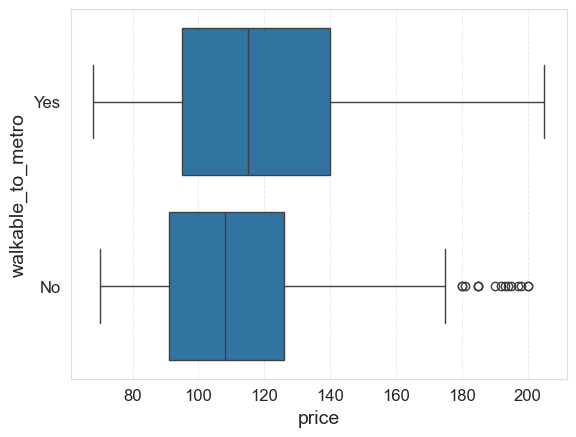

In [33]:
sns.boxplot(flats, x="price", y="walkable_to_metro", orient="h")
plt.show()

In [34]:
flats.groupby("walkable_to_metro")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
walkable_to_metro,,,,,,,,
No,619.0,111.607431,26.257981,70.0,91.0,108.0,126.0,200.0
Yes,1249.0,119.949560,29.321819,68.0,95.0,115.0,140.0,205.0


**Промежуточные заметки:**

- Пешая доступность (Yes) — **1249 объектов** (~67%), без — **619** (~33%).
- Медиана: **Yes ≈ 115 млн**, **No ≈ 108 млн** → разница **+7 млн** (~+6.5%).
- Среднее: **Yes ≈ 119.9 млн**, **No ≈ 111.6 млн** → разница **+8.3 млн**.
- Разброс чуть выше у Yes → рядом с метро есть и массовые, и премиум-объекты.
- Диапазон цен схож → влияние через смещение медианы, а не расширение диапазона.

In [35]:
test_mannwhitney(flats, "price", "walkable_to_metro", alternative="two-sided")

walkable_to_metro: p-value=0.0000 → Есть статистически значимая разница.


### 🔍 Вывод

Так как **p-value < 0.05**, нулевая гипотеза **H₀ отвергается**.

- **Пешая доступность до метро оказывает статистически значимое влияние на цену.**
- Квартиры рядом с метро имеют **значимо более высокие средние и медианные цены** (на ~7–8 млн дороже).
Эффект подтверждается статистически и визуально.

---

---
## Анализ влияния **материала дома (кирпичный или нет)** на цену

### Гипотезы:
- **H₀**: Нет значимых различий в цене между квартирами **в кирпичных домах** и **в домах из других материалов**.
- **H₁**: Цены **значимо различаются** в зависимости от материала дома.

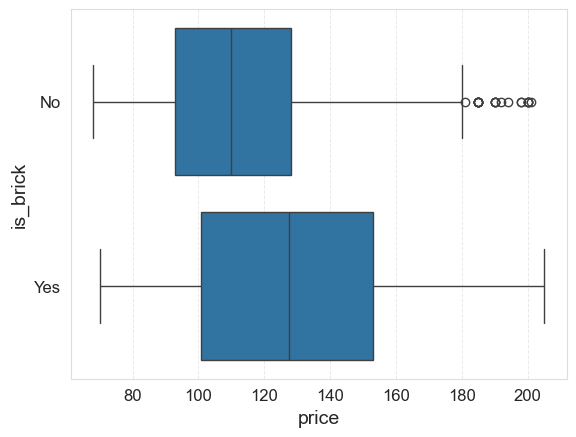

In [36]:
sns.boxplot(flats, x="price", y="is_brick", orient="h")
plt.show()

In [37]:
flats.groupby("is_brick")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
is_brick,,,,,,,,
No,1316.0,112.563830,25.443707,68.0,93.00,110.0,128.0,201.0
Yes,552.0,128.202899,32.485464,70.0,100.75,127.5,153.0,205.0


**Промежуточные заметки:**

- Кирпичные дома (Yes) — **552 объекта** (~30%).
- Медиана: **Yes ≈ 127.5 млн**, **No ≈ 110 млн** → разница **+17.5 млн** (~+15.9%).
- Среднее выше медианы в обеих группах → распределение с правой асимметрией.
- Разброс выше у Yes → кирпич включает и средний, и премиум-класс.
- Кирпич ассоциируется с долговечностью, тепло- и шумоизоляцией, статусом.

In [38]:
test_mannwhitney(flats, "price", "is_brick", alternative="two-sided")

is_brick: p-value=0.0000 → Есть статистически значимая разница.


### 🔍 Вывод

Так как **p-value < 0.05**, нулевая гипотеза **H₀ отвергается**.

- **Материал дома оказывает статистически значимое влияние на цену.**
- Квартиры в кирпичных домах **значимо дороже** (в среднем на ~16 млн).
- Эффект объясняется качеством и статусом кирпичных зданий.

---

---

## Анализ влияния **этажа (не первый и не последний)** на цену

### Гипотезы:
- **H₀**: Нет значимых различий в цене между квартирами **на промежуточных этажах** (не первый и не последний) и **на крайних этажах** (первый или последний).
- **H₁**: Цены **значимо различаются** в зависимости от расположения этажа (промежуточный vs крайний).

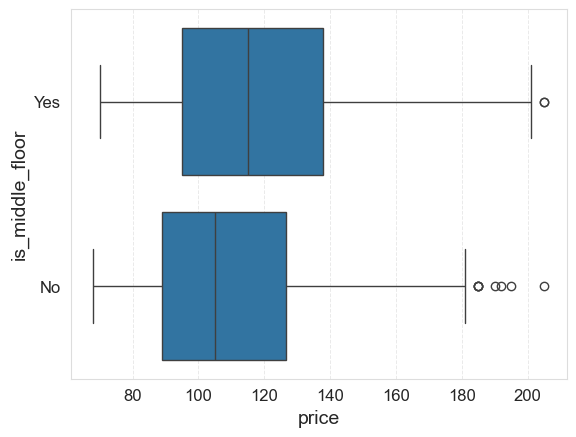

In [39]:
sns.boxplot(flats, x="price", y="is_middle_floor", orient="h")
plt.show()

In [40]:
flats.groupby("is_middle_floor")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
is_middle_floor,,,,,,,,
No,407.0,110.167076,27.436655,68.0,89.0,105.0,126.5,205.0
Yes,1461.0,119.140315,28.628923,70.0,95.0,115.0,138.0,205.0


**Промежуточные заметки:**
- Средние этажи (Yes) — **1461 объект** (~78%), крайние (No) — **407** (~22%).
- Медиана: **Yes ≈ 115 млн**, **No ≈ 105 млн** → разница **+10 млн** (~+9.5%).
- Среднее: **Yes ≈ 119.1 млн**, **No ≈ 110.2 млн** → разница **+8.9 млн**.
- Разброс схож → вариативность не зависит от этажа.
- Диапазон цен одинаков → влияние через смещение медианы.
- Средние этажи предпочтительнее: меньше шума, лучше вид, удобство.

In [42]:
test_mannwhitney(flats, "price", "is_middle_floor", alternative="two-sided")

is_middle_floor: p-value=0.0000 → Есть статистически значимая разница.


### 🔍 Вывод

Так как **p-value < 0.05**, нулевая гипотеза **H₀ отвергается**.

- **Расположение на промежуточном этаже оказывает статистически значимое влияние на цену.**
- Квартиры на средних этажах имеют **значимо более высокие средние и медианные цены** (на ~9–10 млн дороже).
- Эффект подтверждается статистически и визуально.

---

### 🎯 **Итоговый вывод по проверке гипотез**

**Все исследованные признаки оказывают статистически значимое влияние на цену квартир в Москве** (p-value < 0.05 для каждого теста).
**Наблюдаемые зависимости можно переносить с выборки на генеральную совокупность.**

---

#### **1. Количественные признаки** (корреляция Спирмена)

| Признак                | Корреляция | Интерпретация |
|------------------------|------------|----------------|
| `total_area`           | **+0.769** | Сильная: чем больше общая площадь — тем выше цена |
| `living_area`          | **+0.650** | Сильная: жилая площадь напрямую влияет на стоимость |
| `kitchen_area`         | **+0.635** | Сильная: большая кухня повышает цену |
| `distance_to_center`   | **-0.318** | Умеренная: чем дальше от центра — тем ниже цена |
| `distance_to_metro`    | **-0.103** | Слабая: удалённость от метро снижает цену |

> **Вывод:** Площадь — **главный драйвер цены**, расстояния — **второстепенный, но значимый фактор**.

---

#### **2. Бинарные категориальные признаки** (U-критерий Манна–Уитни)

| Признак                     | Эффект на цену | Разница (млн ₽) | % прирост |
|-----------------------------|----------------|------------------|-----------|
| `close_to_center` = Yes     | +20.4          | +23 (медиана)   | **+20.5%** |
| `walkable_to_metro` = Yes   | +8.3           | +7 (медиана)    | **+6.5%**  |
| `is_brick` = Yes            | +15.6          | +17.5 (медиана) | **+15.9%** |
| `is_middle_floor` = Yes     | +8.9           | +10 (медиана)   | **+9.5%**  |

> **Вывод:**
> - **Пешая доступность до центра** — **самый мощный премиум-фактор** (+20%).
> - **Кирпич, метро и средний этаж** — **надёжные драйверы стоимости** (+6–16%).

---

#### **3. Многогрупповой признак** (тест Крускала–Уоллиса)

| `room_type`       | Медиана (млн ₽) | Среднее (млн ₽) |
|-------------------|------------------|------------------|
| 1-комнатная       | **80**           | 81.9             |
| 2-комнатная       | **93**           | 94.9             |
| 3-комнатная       | **120**          | 124.4            |
| 4+ комнат         | **140**          | 143.7            |

> **Вывод:** **Чёткая иерархия**: каждая дополнительная комната увеличивает цену на **15–20 млн**.
> Разброс растёт с числом комнат → **большие квартиры = премиум-сегмент с высокой вариативностью цен**.

---

### 📊 **Обобщение: ключевые факторы ценообразования**

| Ранг | Фактор                     | Влияние на цену |
|------|----------------------------|------------------|
| 1    | **Общая площадь**          | Сильнее всего |
| 2    | **Пешая доступность до центра** | +20% |
| 3    | **Количество комнат**      | +15–20 млн/комната |
| 4    | **Кирпичный дом**          | +16% |
| 5    | **Средний этаж**           | +9–10% |
| 6    | **Пешая доступность до метро** | +6–8% |

---

### ✅ **Финальный вердикт**

> **Все нулевые гипотезы H₀ отвергнуты.**
> **Каждый исследованный признак значимо влияет на цену.**
> **Альтернативные гипотезы H₁ подтверждены.**
> **Модель, построенная на этих признаках, будет обобщаемой и применимой к рынку Москвы в целом.**

**Рекомендация:** Использовать **все признаки** в прогнозировании цены — они **статистически подтверждены** и имеют **практический смысл**.